# <center> SOUTH SUDAN </center>
## <center> Can we find patterns? </center>
#### <center> Aart Odding \& Bram ter Huurne </center>


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as tckr
from shapely.geometry import Point

https://data2.unhcr.org/en/situations/southsudan

GEO data:
- https://data.humdata.org/dataset/south-sudan-administrative-boundaries
- https://data.humdata.org/group/ssd?organization=ocha-south-sudan
- roads: https://datacatalog.worldbank.org/dataset/south-sudan-roads

Analysis:
- GeoPandas
- PySAL https://pysal.readthedocs.io/en/latest/

# Attain and acquire data

## South Sudan

In [2]:
ssd_1 = gpd.read_file("GEODATA/southsudan/level1/ssd_admbnda_adm1_imwg_nbs_20180817.shp")
ssd_2 = gpd.read_file("GEODATA/southsudan/level2/ssd_admbnda_adm2_imwg_nbs_20180817.shp")

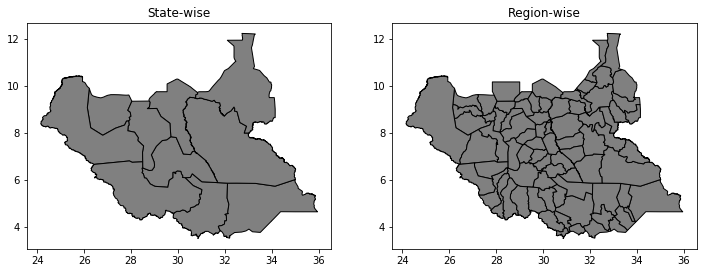

In [3]:
fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(121)
ax1 = ssd_1.plot(ax=ax1,color='gray', edgecolor='black')
ax1.set_aspect('equal')
ax1.set_title('State-wise')
ax2 = fig.add_subplot(122)
ax2 = ssd_2.plot(ax=ax2,color='gray', edgecolor='black')
ax2.set_aspect('equal')
ax2.set_title('Region-wise')
plt.show()

## Conflict-data

There is some duplicate data, where the activity is the same but the people involved are not. 

In [4]:
labels_to_drop = ["data_id", "iso", "event_id_cnty", \
                  "country","year", "region", "time_precision", "geo_precision", "timestamp", "iso3"]
                  
conflicts = pd.read_csv("UN_SouthSudan/ACLED_south-sudan_filt.csv", parse_dates=['event_date'],index_col=['event_date'])
conflicts.drop(labels = labels_to_drop, axis = 'columns', inplace = True)

In [5]:
conflicts['coordinates'] = list(zip(conflicts.longitude, conflicts.latitude))
conflicts['coordinates'] = conflicts['coordinates'].apply(Point)
conflicts.sort_index(inplace=True)
conflicts_geo = gpd.GeoDataFrame(conflicts, geometry='coordinates')
conflicts_geo.head(3)

,event_id_no_cnty,event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,admin1,admin2,admin3,location,latitude,longitude,source,source_scale,notes,fatalities,coordinates
event_date,,,,,,,,,,,,,,,,,,,,
2011-03-08,5,Strategic development,SSLM/A: South Sudan Liberation Movement/Army,NaN,2,NaN,NaN,0,20,Central Equatoria,Juba,Juba,Juba,4.8609,31.6178,Platts Commodity News; Small Arms Survey,Other,Agreement: The newly formed SSLM/A of Peter Ga...,0,POINT (31.6178 4.8609)
2011-03-11,35,Strategic development,Police Forces of South Sudan (2011-),NaN,1,UDF: United Democratic Front,NaN,3,13,Western Equatoria,Mundri East,NaN,Chief Jambo,5.0626,30.7319,Agence France Presse,International,Arrests: South Sudan has arrested a prominent ...,0,POINT (30.7319 5.0626)
2011-04-09,25,Battle-No change of territory,LRA: Lords Resistance Army,NaN,2,Police Forces of South Sudan (2011-),NaN,1,12,Western Bahr el Ghazal,Raga,Raja,Raja,8.4624,25.6810,The Resolve Crisis Initiative,Local,A large group of LRA attacked a police station...,0,POINT (25.681 8.462400000000001)


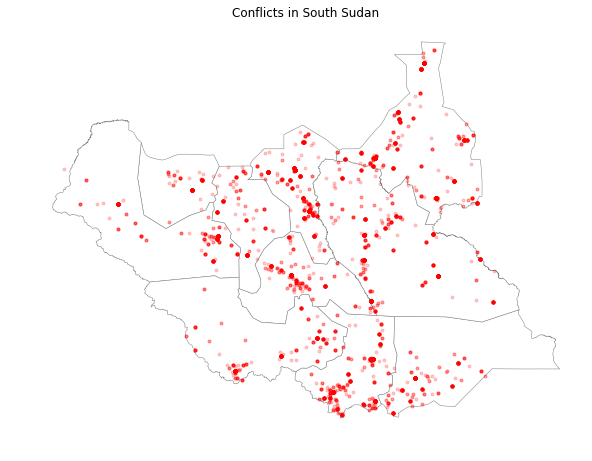

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ssd_1.plot(ax=ax, color='white', edgecolor='0.5',linewidth=0.5)
conflicts_geo['coordinates'].plot(ax=ax,color='red',alpha=0.2,marker='.')
ax.set_title('Conflicts in South Sudan')
ax.axis('off')
plt.show()

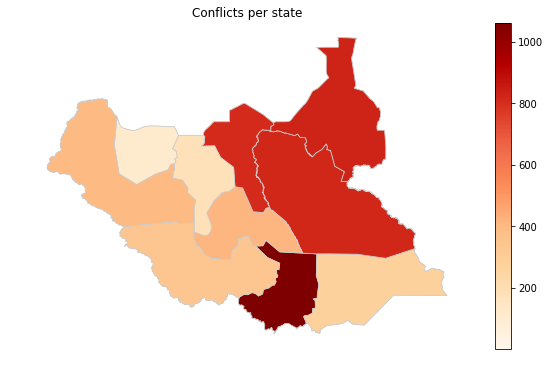

In [7]:
conflicts_geo_count_1 = gpd.GeoDataFrame(conflicts_geo.groupby("admin1").count()['coordinates'])
conflicts_geo_count_1.columns = ['counts']

merged_ssd_1_conflicts = conflicts_geo_count_1.join(ssd_1.set_index('ADM1_EN'))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ssd_1.plot(ax=ax, color='white', edgecolor='0.8',linewidth=0.5)
merged_ssd_1_conflicts.plot(column='counts', cmap='OrRd', linewidth=0.8, legend=True, ax=ax, edgecolor='0.8')
ax.set_title('Conflicts per state')
ax.axis('off')
plt.show()

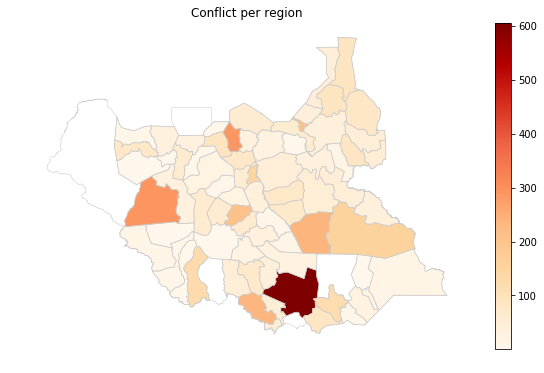

In [8]:
conflicts_geo_count_2 = gpd.GeoDataFrame(conflicts_geo.groupby("admin2").count()['coordinates'])
conflicts_geo_count_2.columns = ['counts']

merged_ssd_2_conflicts = conflicts_geo_count_2.join(ssd_2.set_index('ADM2_EN'))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ssd_2.plot(ax=ax, color='white', edgecolor='0.8',linewidth=0.5)
merged_ssd_2_conflicts.plot(column='counts', cmap='OrRd', legend=True, linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title('Conflict per region')
ax.axis('off')
plt.show()

Clearly a big peak can be seen in the main capital, Juba. 

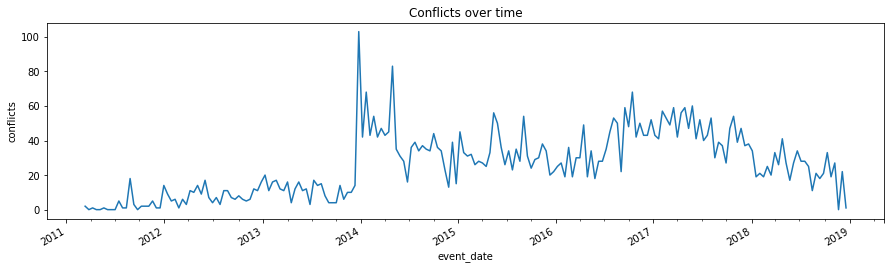

In [9]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
conflicts_geo.reset_index().resample('2w',on='event_date').fatalities.count().plot(ax=ax)
ax.set_ylabel('conflicts')
ax.set_title('Conflicts over time')
fig.autofmt_xdate()
plt.show()





## Fatalities

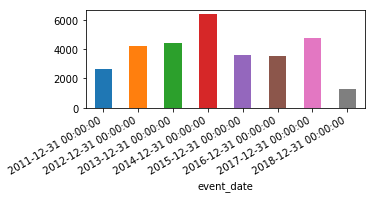

In [10]:
fig = plt.figure(figsize=(5,2))
ax = fig.add_subplot(111)
conflicts_geo['fatalities'].reset_index().resample('y',on='event_date')['fatalities'].sum().plot.bar(ax=ax)
fig.autofmt_xdate()
plt.show()

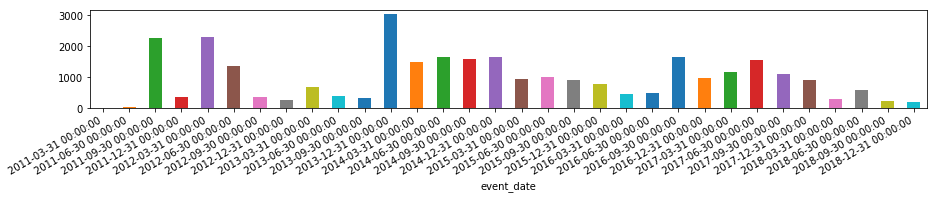

In [11]:
fig = plt.figure(figsize=(15,2))
ax = fig.add_subplot(111)
conflicts_geo['fatalities'].reset_index().resample('q',on='event_date')['fatalities'].sum().plot.bar(ax=ax)
fig.autofmt_xdate()
plt.show()

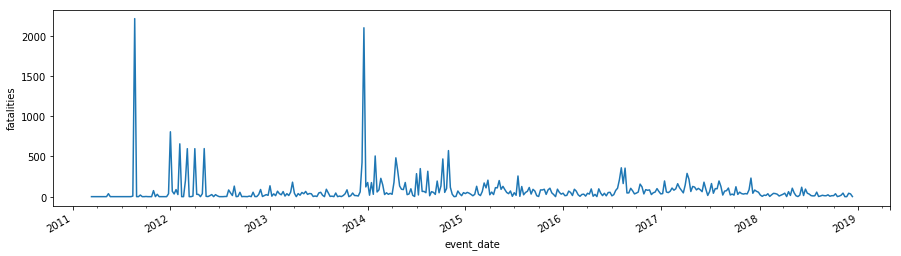

In [12]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
conflicts_geo['fatalities'].reset_index().resample('w',on='event_date')['fatalities'].sum().plot(ax=ax)
ax.set_ylabel('fatalities')
fig.autofmt_xdate()
plt.show()

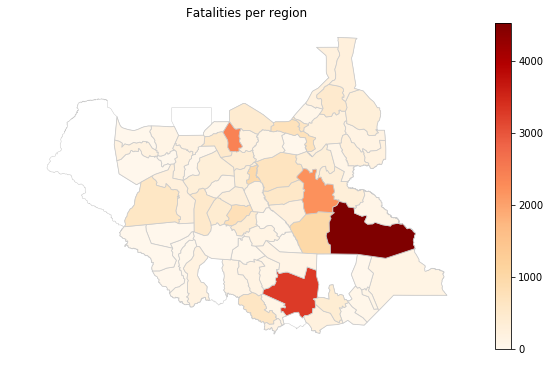

In [13]:
conflicts_geo_sum_2 = gpd.GeoDataFrame(conflicts_geo.groupby("admin2").fatalities.sum())
merged_ssd_2_fatalities = conflicts_geo_sum_2.join(ssd_2.set_index('ADM2_EN'))

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ssd_2.plot(ax=ax, color='white', edgecolor='0.8',linewidth=0.5)
merged_ssd_2_fatalities.plot(column='fatalities', cmap='OrRd', legend=True, linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title('Fatalities per region')
ax.axis('off')
plt.show()

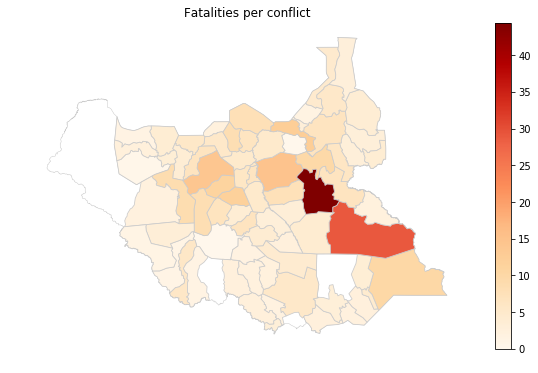

In [14]:
conflicts_geo_fatalities = conflicts_geo.groupby('admin2').fatalities
fatalities_per_conflict = conflicts_geo_fatalities.sum()/conflicts_geo_fatalities.count()
fatalities_per_conflict = ssd_2.set_index('ADM2_EN').join(fatalities_per_conflict)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ssd_1.plot(ax=ax, color='white', edgecolor='0.8',linewidth=0.5)
fatalities_per_conflict[fatalities_per_conflict.fatalities.notnull()].plot(column='fatalities', cmap='OrRd', legend=True, linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title('Fatalities per conflict')
ax.axis('off')
plt.show()

We notice some obscurity in the data here. Pibor apparantly has 4 months sequential 597 deaths. 

## Price-data

In [15]:
labels_to_drop = ["default", "admname", "adm1id","ptid","sn"]

prices = pd.read_csv("UN_SouthSudan/wfp_food_prices_south-sudan_filt.csv", parse_dates=['date'],index_col=['date'])
prices.drop(labels = labels_to_drop, axis = 'columns', inplace = True)


In [16]:
prices['coordinates'] = list(zip(prices.long, prices.lat))
prices['coordinates'] = prices['coordinates'].apply(Point)
prices_geo = gpd.GeoDataFrame(prices, geometry='coordinates')
prices_geo.head(3)

,cmname,unit,category,price,currency,country,mktname,mktid,cmid,umid,catid,lat,long,coordinates
date,,,,,,,,,,,,,,
2012-01-15,Fuel (diesel) - Retail,L,non-food,7.9063,SSP,South Sudan,National Average,1199,284,15,8,NaN,NaN,POINT (nan nan)
2012-02-15,Fuel (diesel) - Retail,L,non-food,7.2750,SSP,South Sudan,National Average,1199,284,15,8,NaN,NaN,POINT (nan nan)
2012-03-15,Fuel (diesel) - Retail,L,non-food,7.4531,SSP,South Sudan,National Average,1199,284,15,8,NaN,NaN,POINT (nan nan)


## Count which products are most abundant in database

In [17]:
cm_max_vals = {}
for market in prices_geo.mktname.unique():  # name all markets
    cm_max_vals[market] = prices_geo[prices_geo.mktname == market].cmname.value_counts()
cm_max_vals = pd.DataFrame.from_dict(cm_max_vals)

In [18]:
cm_max_vals

,National Average,Rumbek,Mingkaman,Bentiu,Yida,Konyo Konyo,Torit,Bor,Aweil (Town),Kuajok,Wunrok,Jau,Yambio,Malakal
Beans (red) - Retail,NaN,71.0,37.0,61.0,12.0,105.0,34.0,89.0,99.0,35.0,35.0,100.0,36.0,70.0
Cassava (dry) - Retail,NaN,NaN,NaN,NaN,NaN,59.0,NaN,NaN,2.0,NaN,NaN,56.0,NaN,NaN
Cassava - Retail,NaN,5.0,NaN,NaN,NaN,33.0,16.0,NaN,4.0,NaN,NaN,32.0,1.0,NaN
Exchange rate (unofficial) - Retail,35.0,2.0,NaN,2.0,NaN,16.0,NaN,3.0,6.0,NaN,NaN,NaN,NaN,NaN
Exchange rate - Retail,35.0,NaN,NaN,NaN,NaN,13.0,NaN,2.0,3.0,NaN,NaN,NaN,NaN,NaN
Fuel (diesel) - Retail,24.0,44.0,NaN,30.0,8.0,62.0,12.0,54.0,63.0,29.0,NaN,63.0,1.0,33.0
"Fuel (diesel, parallel market) - Retail",NaN,3.0,3.0,1.0,3.0,2.0,2.0,2.0,3.0,NaN,1.0,3.0,2.0,1.0
Fuel (petrol-gasoline) - Retail,24.0,41.0,NaN,28.0,7.0,60.0,12.0,55.0,64.0,28.0,NaN,61.0,1.0,28.0
"Fuel (petrol-gasoline, parallel market) - Retail",NaN,2.0,3.0,1.0,2.0,3.0,1.0,1.0,3.0,NaN,1.0,2.0,1.0,1.0
Groundnuts (shelled) - Retail,NaN,73.0,1.0,44.0,5.0,119.0,31.0,95.0,99.0,39.0,1.0,95.0,1.0,80.0


In [19]:
print(f'Total entries in list:\n\n{cm_max_vals.sum(axis=1).sort_values().tail(5)}')

Total entries in list:

Wheat flour - Retail                  568.0
Maize (white) - Retail                625.0
Groundnuts (shelled) - Retail         683.0
Beans (red) - Retail                  784.0
Sorghum (white, imported) - Retail    902.0
dtype: float64


From this overview we see that it makes sense to choose Red Beans and White Imported Sorghum as the correct indicator, since it has over 10 entries in all markets.

## Check for inflation

In [20]:
print('Red beans not in SSP: ',np.sum(prices_geo[prices_geo.cmname == 'Beans (red) - Retail'].currency != 'SSP'))
print('Imported Sorghum not in SSP: ',np.sum(prices_geo[prices_geo.cmname == 'Sorghum (white, imported) - Retail'].currency != 'SSP'))

Red beans not in SSP:  0
Imported Sorghum not in SSP:  0


We can use the SSP currency as the currency to check for inflation

In [21]:
def plot_price(prices,name,alpha=1,logy=False):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    price_mean = []
    for market in prices.mktname.unique():  # name all markets
        prices[prices.mktname == market].price.plot(ax=ax,marker='.',alpha=alpha,logy=logy)
        
    
    ax.legend(prices.mktname.unique())    
    ax.set_title(f'Price of {name} (SSP)')
    ax.set_ylabel('Price (SSP)')
    plt.show()

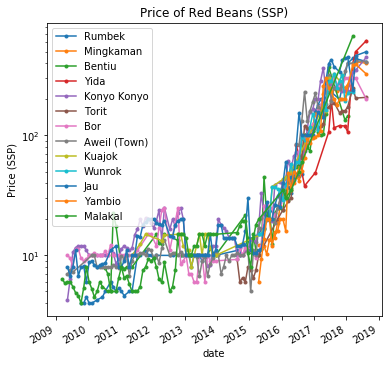

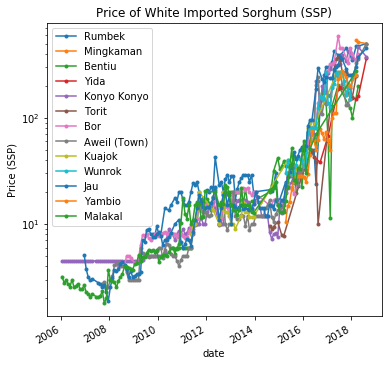

In [22]:
prices_geo_beans = prices_geo[prices_geo.cmname == 'Beans (red) - Retail']
prices_geo_sorghum = prices_geo[prices_geo.cmname == 'Sorghum (white, imported) - Retail']

plot_price(prices_geo_beans,'Red Beans',logy=True)
plot_price(prices_geo_sorghum,'White Imported Sorghum',logy=True)

In [23]:
def create_diff_gdf(prices):
    prices_geo_diff = pd.concat([pd.DataFrame([[market,
                                                  prices[prices.mktname == market].iloc[-1].price/prices[prices.mktname == market].iloc[0].price,
                                                  prices[prices.mktname == market].reset_index().date.iloc[-1]-prices[prices.mktname == market].reset_index().date.iloc[0],
                                                  prices[prices.mktname == market].coordinates[0]]], 
                                                columns=['mktname','pricediff','time','coordinates']) 
                                       for market in prices.mktname.unique()],
                                      ignore_index=True)   
    prices_geo_diff = gpd.GeoDataFrame(prices_geo_diff, geometry='coordinates')
    
    return prices_geo_diff

In [24]:
prices_geo_sorghum_diff = create_diff_gdf(prices_geo_sorghum)
prices_geo_beans_diff = create_diff_gdf(prices_geo_beans)

In [25]:
def put_in_region(prices_diff,ssd_2):
    prices_diff_admin2 = {}
    for region,name in zip(ssd_2.geometry,ssd_2.ADM2_EN):
        for price,coordinate in zip(prices_diff.pricediff,prices_diff.coordinates):
            if coordinate.within(region):
                prices_diff_admin2[name] = price,region

    prices_diff_admin2 = pd.DataFrame.from_dict(prices_diff_admin2,orient='index')
    prices_diff_admin2.columns = ['inflation','geometry']
    prices_diff_admin2 = gpd.GeoDataFrame(prices_diff_admin2, geometry='geometry')
    
    return prices_diff_admin2

In [26]:
prices_geo_admin2_beans_diff = put_in_region(prices_geo_beans_diff,ssd_2)
prices_geo_admin2_sorghum_diff = put_in_region(prices_geo_sorghum_diff,ssd_2)

In [27]:
def plot_inflation(prices_diff_admin2,ssd_2,merged_ssd_2_conflicts,cmname):
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(121)
    ax1.set_aspect('equal')
    ssd_2.plot(ax=ax1, color='white', edgecolor='0.8',linewidth=0.5)
    prices_diff_admin2.plot(column='inflation', cmap='OrRd', linewidth=0.8, legend=True, ax=ax1, edgecolor='0.8')
    ax1.axis('off')
    ax1.set_title(f'Inflation of {cmname} per region')

    ax2 = fig.add_subplot(122)
    ax2.set_aspect('equal')
    ssd_2.plot(ax=ax2, color='white', edgecolor='0.8',linewidth=0.5)
    merged_ssd_2_conflicts.plot(column='counts', cmap='OrRd', legend=True, linewidth=0.8, ax=ax2, edgecolor='0.8')
    ax2.axis('off')
    ax2.set_title('Conflict per region')
    
    
    plt.show()

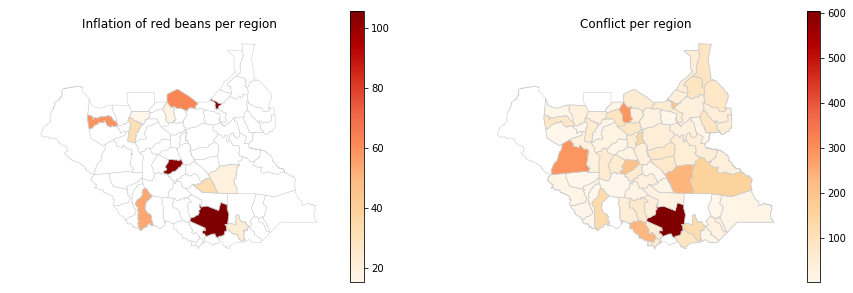

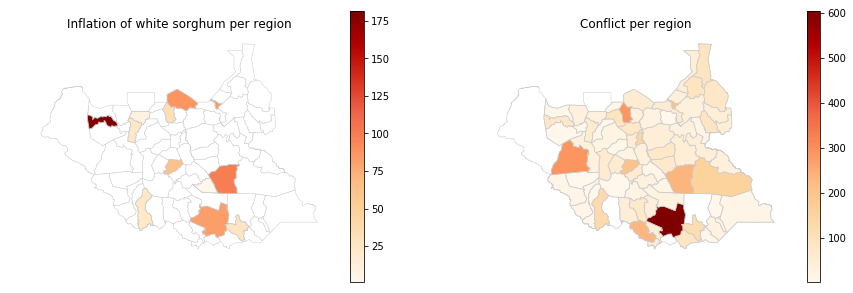

In [28]:
plot_inflation(prices_geo_admin2_beans_diff,ssd_2,merged_ssd_2_conflicts,'red beans')
plot_inflation(prices_geo_admin2_sorghum_diff,ssd_2,merged_ssd_2_conflicts,'white sorghum')

We see that We se that finlation happens in regions where there are also conflicts, but not everywhere where there are conflicts, prices have risen extremely.

## Exchange rates

In [29]:
exchange_off = prices_geo[prices_geo.cmname == 'Exchange rate - Retail']
exchange_unoff = prices_geo[prices_geo.cmname == 'Exchange rate (unofficial) - Retail']

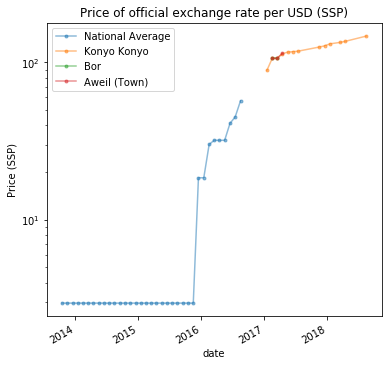

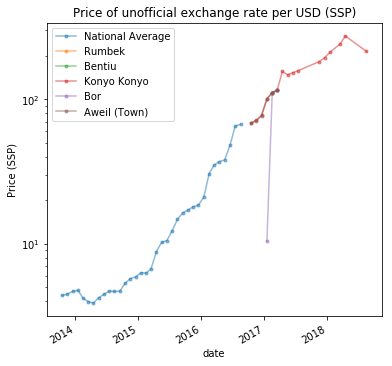

In [30]:
plot_price(exchange_off,'official exchange rate per USD',alpha=0.5,logy=True)
plot_price(exchange_unoff,'unofficial exchange rate per USD',alpha=0.5,logy=True)

## Import refugee data

In [31]:
def prep_ref_data(df):
    df = df.drop('unix_timestamp',axis=1)
    df = df.set_index('data_date')
    df.index = pd.to_datetime(df.index)
    df.index.name = 'date'
    return df

In [32]:
ref_congo = pd.DataFrame(pd.read_json("UN_SouthSudan/refugees to DRC.json").data.timeseries)
ref_kenya = pd.DataFrame(pd.read_json("UN_SouthSudan/refugees to Kenya.json").data.timeseries)
ref_sudan = pd.DataFrame(pd.read_json("UN_SouthSudan/refugees to Sudan.json").data.timeseries)
ref_uganda = pd.DataFrame(pd.read_json("UN_SouthSudan/refugees to Uganda.json").data.timeseries)
ref_ethiopia = pd.DataFrame(pd.read_json("UN_SouthSudan/refugees to Ethiopia.json").data.timeseries)

ref_congo = prep_ref_data(ref_congo)
ref_kenya = prep_ref_data(ref_kenya)
ref_sudan = prep_ref_data(ref_sudan)
ref_uganda = prep_ref_data(ref_uganda)
ref_ethiopia = prep_ref_data(ref_ethiopia)

## Refugee data

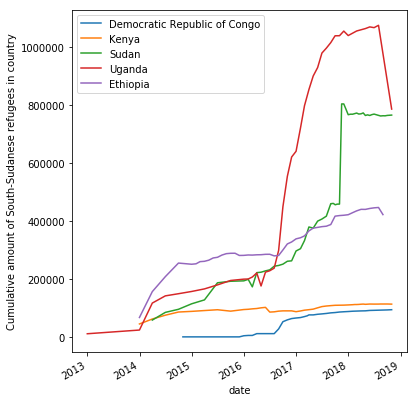

In [33]:
fig = plt.figure(figsize=(6,7))
ax = fig.add_subplot(111)
ref_congo.plot(ax=ax,label='Congo')
ref_kenya.plot(ax=ax,label='Kenya')
ref_sudan.plot(ax=ax,label='Sudan')
ref_uganda.plot(ax=ax,label='Uganda')
ref_ethiopia.plot(ax=ax,label='Ethiopia')
ax.set_ylabel("Cumulative amount of South-Sudanese refugees in country")
ax.legend(['Democratic Republic of Congo','Kenya','Sudan','Uganda','Ethiopia'])
plt.show()

## Food prices vs refugees per region over time

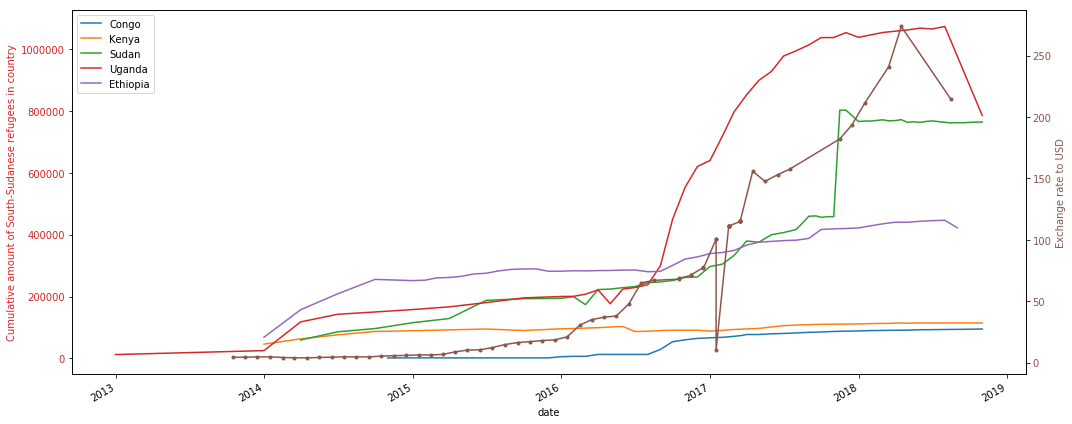

In [34]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)

color = 'tab:red'
ref_congo.plot(ax=ax,label='Congo')
ref_kenya.plot(ax=ax,label='Kenya')
ref_sudan.plot(ax=ax,label='Sudan')
ref_uganda.plot(ax=ax,label='Uganda')
ref_ethiopia.plot(ax=ax,label='Ethiopia')
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylabel("Cumulative amount of South-Sudanese refugees in country", color=color)
ax.legend(['Congo','Kenya','Sudan','Uganda','Ethiopia'])

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:brown'
exchange_unoff.sort_index().price.plot(ax=ax2,color=color,marker='.')
ax2.set_ylabel('Exchange rate to USD', color=color) 
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



## Road data

In [35]:
roads = gpd.read_file("GEODATA/southsudan/roads/Final_Southern_Sudan_Roads_Version01.shp")

In [36]:
roads_primary = roads[roads.CLASS == 'Primary']
roads_secondary = roads[roads.CLASS == 'Secondary']
roads_unclass = roads[roads.CLASS == 'Non Classified']

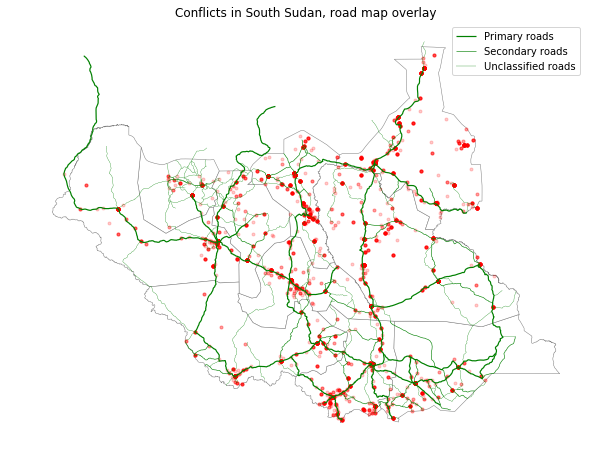

In [37]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ssd_1.plot(ax=ax, color='white', edgecolor='0.5',linewidth=0.5)
roads_primary.plot(ax=ax,color='green',linewidth=1.2,label='Primary roads')
roads_secondary.plot(ax=ax,color='green',linewidth=0.6,label='Secondary roads')
roads_unclass.plot(ax=ax,color='green',linewidth=0.3,label='Unclassified roads')
conflicts_geo['coordinates'].plot(ax=ax,color='red',alpha=0.2,marker='.')
ax.set_title('Conflicts in South Sudan, road map overlay')
ax.legend()
ax.axis('off')
plt.show()

## Neighbouring countries

In [38]:
sdn_1 = gpd.read_file("GEODATA/sudan/level1/sdn_admbndna_adm1_imwg_11302015.shp")
sdn_2 = gpd.read_file("GEODATA/sudan/level2/sdn_admbndna_adm2_imwg_11302015.shp")

drc_1 = gpd.read_file("GEODATA/congo/level1/cod_admbnda_adm1_rgc_20170711.shp")
drc_2 = gpd.read_file("GEODATA/congo/level2/cod_admbnda_adm2_rgc_20170711.shp")

eth = gpd.read_file("GEODATA/ethiopia/ethiopia.shp")

ken_1 = gpd.read_file("GEODATA/kenya/level1/ken_admbnda_adm1_iebc_20180607.shp")
ken_2 = gpd.read_file("GEODATA/kenya/level2/ken_admbnda_adm2_iebc_20180607.shp")

uga_1 = gpd.read_file("GEODATA/uganda/level1/uga_admbnda_adm1_UBOS_v2.shp")
uga_2 = gpd.read_file("GEODATA/uganda/level2/uga_admbnda_adm2_UBOS_v2.shp")

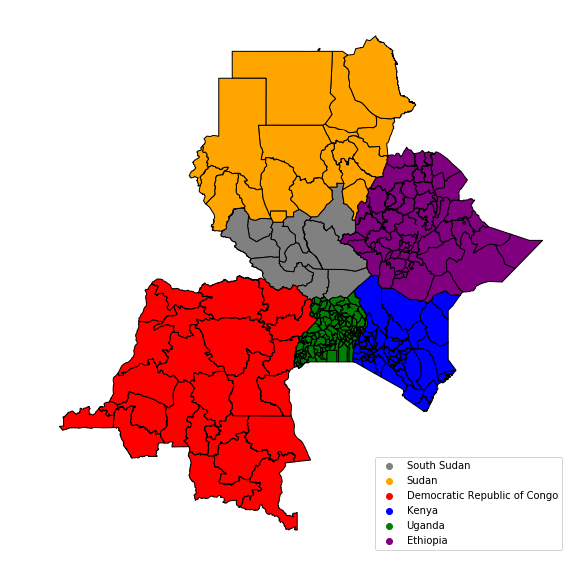

In [39]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ssd_1.plot(ax=ax,color='gray', edgecolor='black',)
ssd_1.head(1).representative_point().plot(ax=ax,color='gray',label='South Sudan')
sdn_1.plot(ax=ax,color='orange', edgecolor='black',label='Sudan')
sdn_1.head(1).representative_point().plot(ax=ax,color='orange',label='Sudan')
drc_1.plot(ax=ax,color='red', edgecolor='black',label='Democratic Republic of Congo')
drc_1.head(1).representative_point().plot(ax=ax,color='red',label='Democratic Republic of Congo')
ken_1.plot(ax=ax,color='blue', edgecolor='black',label='Kenya')
ken_1.head(1).representative_point().plot(ax=ax,color='blue',label='Kenya')
uga_1.plot(ax=ax,color='green', edgecolor='black',label='Uganda')
uga_1.head(1).representative_point().plot(ax=ax,color='green',label='Uganda')
eth.plot(ax=ax,color='purple', edgecolor='black',label='Ethiopia')
eth.head(1).representative_point().plot(ax=ax,color='purple',label='Ethiopia')
ax.set_aspect('equal')
ax.legend(loc='lower right')
ax.axis('off')
plt.show()

In [40]:
ref_congo_tot = ref_congo.individuals[-1]
ref_sudan_tot = ref_sudan.individuals[-1]
ref_kenya_tot = ref_kenya.individuals[-1]
ref_uganda_tot = ref_uganda.individuals[-1]
ref_ethiopia_tot = ref_ethiopia.individuals[-1]

max_ref = max(ref_congo_tot,
              ref_sudan_tot,
              ref_kenya_tot,
              ref_uganda_tot,
              ref_ethiopia_tot)

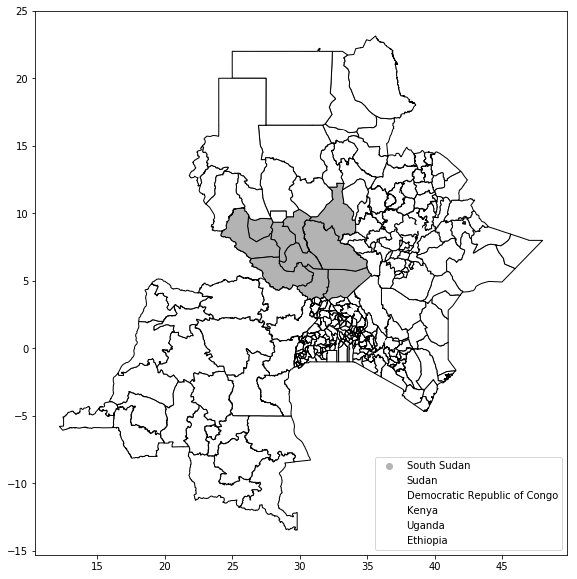

In [41]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ssd_1.plot(ax=ax,color='0.7', edgecolor='black',)
ssd_1.head(1).representative_point().plot(ax=ax,color='0.7',label='South Sudan')
sdn_1.plot(ax=ax,color='white', edgecolor='black',label='Sudan')
sdn_1.head(1).representative_point().plot(ax=ax,color='white',label='Sudan')
drc_1.plot(ax=ax,color='white', edgecolor='black',label='Democratic Republic of Congo')
drc_1.head(1).representative_point().plot(ax=ax,color='white',label='Democratic Republic of Congo')
ken_1.plot(ax=ax,color='white', edgecolor='black',label='Kenya')
ken_1.head(1).representative_point().plot(ax=ax,color='white',label='Kenya')
uga_1.plot(ax=ax,color='white', edgecolor='black',label='Uganda')
uga_1.head(1).representative_point().plot(ax=ax,color='white',label='Uganda')
eth.plot(ax=ax,color='white', edgecolor='black',label='Ethiopia')
eth.head(1).representative_point().plot(ax=ax,color='white',label='Ethiopia')
ax.set_aspect('equal')
ax.legend(loc='lower right')
plt.show()

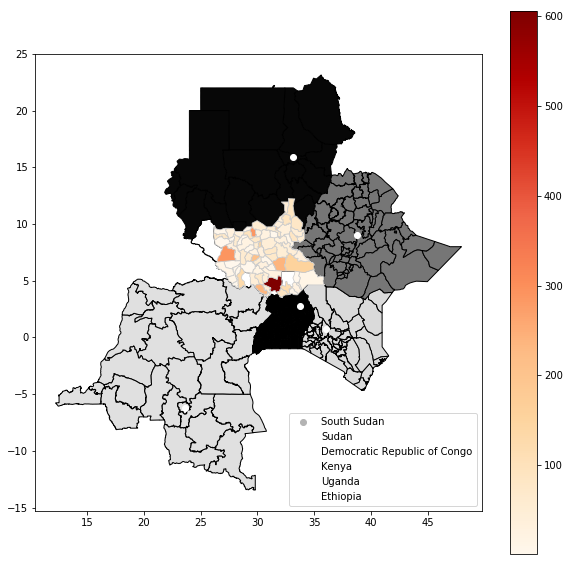

In [42]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ssd_1.plot(ax=ax,color='white', edgecolor='black',)
ssd_1.head(1).representative_point().plot(ax=ax,color='0.7',label='South Sudan')
sdn_1.plot(ax=ax,color=str(1-ref_sudan_tot/max_ref), edgecolor='black',label='Sudan')
sdn_1.head(1).representative_point().plot(ax=ax,color='white',label='Sudan')
drc_1.plot(ax=ax,color=str(1-ref_congo_tot/max_ref), edgecolor='black',label='Democratic Republic of Congo')
drc_1.head(1).representative_point().plot(ax=ax,color='white',label='Democratic Republic of Congo')
ken_1.plot(ax=ax,color=str(1-ref_kenya_tot/max_ref), edgecolor='black',label='Kenya')
ken_1.head(1).representative_point().plot(ax=ax,color='white',label='Kenya')
uga_1.plot(ax=ax,color=str(1-ref_uganda_tot/max_ref), edgecolor='black',label='Uganda')
uga_1.head(1).representative_point().plot(ax=ax,color='white',label='Uganda')
eth.plot(ax=ax,color=str(1-ref_ethiopia_tot/max_ref), edgecolor='black',label='Ethiopia')
eth.head(1).representative_point().plot(ax=ax,color='white',label='Ethiopia')
merged_ssd_2_conflicts.plot(column='counts', cmap='OrRd', linewidth=0.8, legend=True, ax=ax, edgecolor='0.8')

ax.set_aspect('equal')
ax.legend(loc='lower right')
plt.show()

## Population data

In [43]:
popshp = gpd.read_file("GEODATA/southsudan/pop/SouthSudan_AnnualCountyPopulation_20082020.shp")
popshp = popshp.set_index('admin2Name')

pop = pd.read_csv('GEODATA/southsudan/pop/SouthSudan_AnnualCountyPopulation_20082020.csv',index_col='admin2Name')
pop.drop('Unnamed: 14',axis=1,inplace=True)

In [44]:
pop.head(5)

,SS2008,SS2009,SS2010,SS2011,SS2012,SS2013,SS2014,SS2015,SS2016,SS2017,SS2018,SS2019,SS2020
admin2Name,,,,,,,,,,,,,
Abiemnhom,17397,18112,18846,19687,20562,21460,22379,23336,24339,25384,26472,27577,28736
Abyei region,53130,55238,57363,59693,62053,64430,66835,69316,71884,74518,77245,79942,82749
Akobo,137334,142797,148265,153725,158938,164231,169689,175327,186670,192937,199474,205931,212650
Aweil Centre,42829,44582,46367,48107,49899,51727,53537,55410,57339,59356,61432,63513,65723
Aweil East,317527,330521,343754,356658,369938,383492,396916,410799,425100,440055,455442,470782,487253


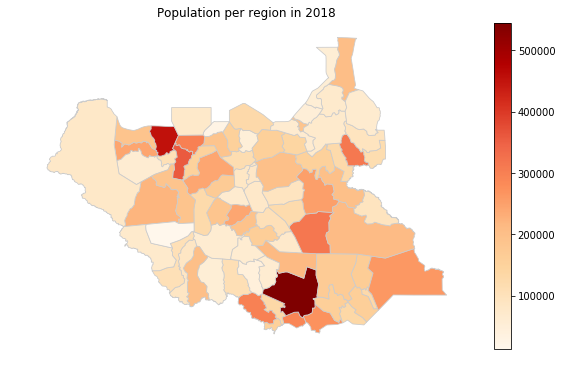

In [45]:
year= 2018

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
#ssd_2.plot(ax=ax, color='white', edgecolor='0.8',linewidth=0.5)
popshp.plot(column=f'SS{year}', cmap='OrRd', legend=True, linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title(f'Population per region in {year}')
ax.axis('off')
plt.show()

In [46]:
popshp['fatalities'] = conflicts_geo.groupby("admin2").fatalities.sum()

In [47]:
def popfat_ratio(popshp,year):
    popshp['ratio'] = popshp['fatalities']/popshp[f'SS{year}']
    return popshp

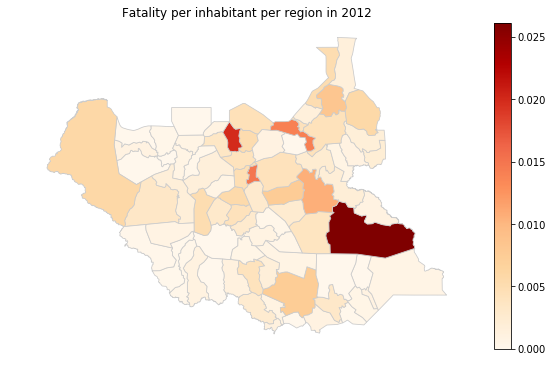

In [48]:
year = 2012
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
popfat_ratio(popshp,year).fillna(0).plot(column='ratio', cmap='OrRd', legend=True, linewidth=0.8, ax=ax, edgecolor='0.8')
ax.set_title(f'Fatality per inhabitant per region in {year}')
ax.axis('off')
plt.show()

## Activity most active groups

Military Forces of South Sudan (2011-)
Civilians (South Sudan)
SPLA/M-In Opposition: Sudanese Peoples Liberation Army/Movement-In Opposition
Unidentified Armed Group (South Sudan)
Police Forces of South Sudan (2011-)
Protesters (South Sudan)
Murle Ethnic Militia (South Sudan)
Unidentified Communal Militia (South Sudan)
Mutiny of Military Forces of South Sudan (2011-)
Military Forces of Sudan (1989-)
[2722, 1869, 1772, 1015, 262, 178, 174, 158, 148, 135]


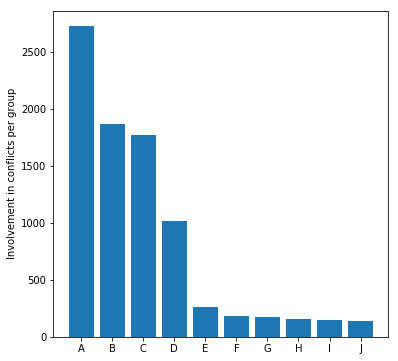

In [49]:
all_actors = list(conflicts.actor1) + list(conflicts.assoc_actor_1) + list(conflicts.actor2) + list(conflicts.assoc_actor_2)

actors = {}

for a in all_actors:
    if a in actors.keys():
        actors[a] += 1
    else:
        actors[a] = 1

actors = list(actors.items())
actors.sort(key = lambda x : x[1], reverse = True)


SHOW_NUM = 10

actor_names = [ a[0] for a in actors[1: 1 + SHOW_NUM] ]
actor_frequencies = [ a[1] for a in actors[1:1 + SHOW_NUM] ] 

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
# legend = '''A: Military Forces of South Sudan\n\
# B: Civilians (South Sudan)\n\
# C: SPLA/M-In Opposition\n\
# D: Unidentified Armed Group (South Sudan)\n\
# E: Police Forces of South Sudan\n\
# F: Protesters (South Sudan)\n\
# G: Murle Ethnic Militia (South Sudan)\n\
# H: Unidentified Communal Militia (South Sudan)\n\
# I: Mutiny of Military Forces of South Sudan\n\
# J: Military Forces of Sudan''' 

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 6
fig_size[1] = 6
#plt.rcParams.update({'font.size': 15})
plt.rcParams["figure.figsize"] = fig_size
plt.ylabel("Involvement in conflicts per group")
#plt.xticks(rotation=-45)
#plt.gcf().subplots_adjust(bottom=0.5)
#plt.tight_layout()
plt.bar(x = np.arange(SHOW_NUM), align = 'center',height = actor_frequencies, width = 0.8, tick_label = labels)
# plt.legend([legend])
plt.savefig("conflicts_per_group.png")

for i in actor_names:
    print(i)

print(actor_frequencies) 



## Correlation of data

In [50]:
ug_corr = pd.merge_asof(ref_uganda,pd.DataFrame(exchange_unoff.price).sort_index(),left_index=True, right_index=True)
ug_corr.corr()

,individuals,price
individuals,1.00000,0.89978
price,0.89978,1.00000


In [51]:
ug_corr = pd.merge_asof(ref_congo,pd.DataFrame(exchange_unoff.price).sort_index(),left_index=True, right_index=True)
ug_corr.corr()

,individuals,price
individuals,1.00000,0.90371
price,0.90371,1.00000


In [52]:
ug_corr = pd.merge_asof(ref_sudan,pd.DataFrame(exchange_unoff.price).sort_index(),left_index=True, right_index=True)
ug_corr.corr()

,individuals,price
individuals,1.000000,0.944857
price,0.944857,1.000000


In [53]:
ug_corr = pd.merge_asof(ref_ethiopia,pd.DataFrame(exchange_unoff.price).sort_index(),left_index=True, right_index=True)
ug_corr.corr()

,individuals,price
individuals,1.000000,0.888618
price,0.888618,1.000000


In [54]:
ug_corr = pd.merge_asof(ref_kenya,pd.DataFrame(exchange_unoff.price).sort_index(),left_index=True, right_index=True)
ug_corr.corr()

,individuals,price
individuals,1.000000,0.807549
price,0.807549,1.000000


In [ ]:
ug_corr.plot(columns='price')